In [1]:
import tensorflow as tf

In [2]:
print(tf.__version__)

2.2.0


In [3]:
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
data=pd.read_csv('../petfinder_data/favorites_sample_small.csv', delimiter=';',error_bad_lines=False)

In [6]:
data.head(10)

,user_id,favorited_at,id,organization_id,organization_active,organization_enabled,organization_display_id,import_on,import_software,organization_type,...,good_with_other_animals,good_with_others_notes,house_trained,altered,declawed,special_needs,shots_current,num_photos,num_aifs,num_videos
0,4369629,2020-01-01 00:00:04,46861637,44719,1,1,OH1073,0,NaN,Rescue Group / Foster-Based,...,unknown,NaN,0,1,0,1,1,5,11,0
1,4369629,2020-01-01 00:00:07,46898514,35651,1,1,OH745,0,NaN,Rescue Group / Foster-Based,...,unknown,NaN,0,1,0,0,1,2,0,0
2,4112169,2020-01-01 00:00:08,46980809,40518,1,1,NY1044,0,NaN,Rescue Group / Foster-Based,...,unknown,NaN,1,1,0,0,1,6,0,0
3,4369680,2020-01-01 00:00:12,46956517,29207,1,1,FL806,0,NaN,NaN,...,unknown,NaN,0,0,0,0,1,1,1,0
4,4369681,2020-01-01 00:00:13,46860620,48762,1,1,TN914,1,Petfinder Import Standard Template,Rescue Group / Foster-Based,...,unknown,NaN,0,0,0,0,0,3,26,0
5,4369629,2020-01-01 00:00:16,46898681,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,yes,foster has other dogs and cats,0,1,0,0,1,2,5,0
6,4369489,2020-01-01 00:00:17,46559227,26457,1,1,AR96,0,NaN,NaN,...,unknown,NaN,0,1,0,0,1,6,1,0
7,4369629,2020-01-01 00:00:17,46898698,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,yes,foster home has other dogs and cats,1,0,0,0,1,1,2,0
8,4369629,2020-01-01 00:00:18,46898687,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,yes,foster has other dogs and cats,0,1,0,0,1,1,3,0
9,4369682,2020-01-01 00:00:20,46934463,42387,1,1,NC823,0,NaN,NaN,...,unknown,NaN,0,0,0,0,1,6,2,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140969 entries, 0 to 140968
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         140969 non-null  int64  
 1   favorited_at                    140969 non-null  object 
 2   id                              140969 non-null  int64  
 3   organization_id                 140969 non-null  int64  
 4   organization_active             140969 non-null  int64  
 5   organization_enabled            140969 non-null  int64  
 6   organization_display_id         140969 non-null  object 
 7   import_on                       140969 non-null  int64  
 8   import_software                 61836 non-null   object 
 9   organization_type               109264 non-null  object 
 10  location_type                   140969 non-null  object 
 11  is_public_location              140969 non-null  int64  
 12  state_code      

In [8]:
data['Description_Flag'] = np.where(data['pet_description'].notnull(), 1, 0)

In [9]:
data['organization_type'].fillna("Unknown", inplace = True) 

In [10]:
data.head(10)

,user_id,favorited_at,id,organization_id,organization_active,organization_enabled,organization_display_id,import_on,import_software,organization_type,...,good_with_others_notes,house_trained,altered,declawed,special_needs,shots_current,num_photos,num_aifs,num_videos,Description_Flag
0,4369629,2020-01-01 00:00:04,46861637,44719,1,1,OH1073,0,NaN,Rescue Group / Foster-Based,...,NaN,0,1,0,1,1,5,11,0,1
1,4369629,2020-01-01 00:00:07,46898514,35651,1,1,OH745,0,NaN,Rescue Group / Foster-Based,...,NaN,0,1,0,0,1,2,0,0,1
2,4112169,2020-01-01 00:00:08,46980809,40518,1,1,NY1044,0,NaN,Rescue Group / Foster-Based,...,NaN,1,1,0,0,1,6,0,0,1
3,4369680,2020-01-01 00:00:12,46956517,29207,1,1,FL806,0,NaN,Unknown,...,NaN,0,0,0,0,1,1,1,0,1
4,4369681,2020-01-01 00:00:13,46860620,48762,1,1,TN914,1,Petfinder Import Standard Template,Rescue Group / Foster-Based,...,NaN,0,0,0,0,0,3,26,0,0
5,4369629,2020-01-01 00:00:16,46898681,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,foster has other dogs and cats,0,1,0,0,1,2,5,0,1
6,4369489,2020-01-01 00:00:17,46559227,26457,1,1,AR96,0,NaN,Unknown,...,NaN,0,1,0,0,1,6,1,0,1
7,4369629,2020-01-01 00:00:17,46898698,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,foster home has other dogs and cats,1,0,0,0,1,1,2,0,1
8,4369629,2020-01-01 00:00:18,46898687,49615,1,1,OH1248,0,NaN,Rescue Group / Foster-Based,...,foster has other dogs and cats,0,1,0,0,1,1,3,0,1
9,4369682,2020-01-01 00:00:20,46934463,42387,1,1,NC823,0,NaN,Unknown,...,NaN,0,0,0,0,1,6,2,0,1


In [11]:
print("Unique Values in `Flag_Detail` => {}".format(data.Description_Flag.unique()))

Unique Values in `Flag_Detail` => [1 0]


In [12]:
data_des = data[[
    'Description_Flag'
    ,'pet_description']].copy()

data_des.head()

,Description_Flag,pet_description
0,1,Meet Elsa!Elsa came to us as a stray. She had ...
1,1,Coco came into the rescue a couple years ago w...
2,1,AGE: 1 YearSEX: Neutered MaleWEIGHT: 50 Pounds...
3,1,Very sweet puppy will neuter micrchip and give...
4,0,NaN


In [13]:
data2 = data[[
    'user_id'
    ,'id'
    ,'num_aifs'
    , 'Description_Flag'
    , 'mixed_breed']].copy()

In [14]:
datatest = data[[
    'user_id'
    ,'id'
    ,'Description_Flag'
    ,'mixed_breed'
    ,'animal_type'
    ,'age'
    ,'state_code'
    ,'primary_breed'
    ,'organization_type'
    ,'gender'
    ,'size'
    ,'num_aifs'
    ,'house_trained'
    ,'coat_length'
    ,'num_videos'
    ,'num_photos'
    ,'good_with_dogs'
    ,'good_with_cats'
    ,'good_with_children']].copy()

In [15]:
user_enc = LabelEncoder()
# can later use user_enc like so user_enc.inverse_transform([24230]) to get original user_id
data2['user'] = user_enc.fit_transform(data2['user_id'].values)

pet_enc = LabelEncoder()
data2['pet'] = pet_enc.fit_transform(data2['id'].values)

n_users = data2['user'].nunique()
print(n_users)
n_favorites = data2['pet'].nunique()
print(n_favorites)

24231
63307


In [16]:
# validate encodings start from 0 and index to n_users-1 and n_favorites-1
print(data2.user.min())
print(data2.user.max())
print(data2.pet.min())
print(data2.pet.max())

0
24230
0
63306


In [17]:
train, test = train_test_split(data2, test_size=0.2, random_state=42)

In [18]:
print(train)

        user_id        id  num_aifs  Description_Flag  mixed_breed   user  \
78111   4385007  46212165        10                 1            1  18723   
84237   4385930  46975330         0                 0            0  19139   
47676   4377578  46950410         1                 1            1  15342   
1170    4369877  46941845         0                 1            0  11931   
102441  4342757  46979281         1                 1            1  10092   
...         ...       ...       ...               ...          ...    ...   
110268  4391200  46964272         2                 0            0  21498   
119879  4118284  46262196         8                 1            1   4584   
103694  3908620  46568984         4                 0            0   2536   
131932  4215592  47000204         4                 1            1   6521   
121958  4149300  46809506         0                 1            1   5122   

          pet  
78111   14284  
84237   51634  
47676   45693  
1170    444

In [19]:
fav_input = Input(shape=[1], name="Fav-Input")
fav_embedding = Embedding(n_favorites, 50, name="Fav-Embedding")(fav_input)
fav_vec = Flatten(name="Flatten-Books")(fav_embedding)


user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users, 50, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)


prod = Dot(name="Dot-Product", axes=1)([fav_vec, user_vec])
model = Model([user_input, fav_input], prod)
model.compile('adam', 'mean_squared_error')

Epoch 1/20
3525/3525 [==============================] - 86s 24ms/step - loss: 705.4168
Epoch 2/20
3525/3525 [==============================] - 91s 26ms/step - loss: 702.7872
Epoch 3/20
3525/3525 [==============================] - 89s 25ms/step - loss: 694.2722
Epoch 4/20
3525/3525 [==============================] - 90s 25ms/step - loss: 679.5330
Epoch 5/20
3525/3525 [==============================] - 88s 25ms/step - loss: 660.0684
Epoch 6/20
3525/3525 [==============================] - 87s 25ms/step - loss: 637.2799
Epoch 7/20
3525/3525 [==============================] - 85s 24ms/step - loss: 612.3076
Epoch 8/20
3525/3525 [==============================] - 85s 24ms/step - loss: 586.1474
Epoch 9/20
3525/3525 [==============================] - 85s 24ms/step - loss: 559.3314
Epoch 10/20
3525/3525 [==============================] - 84s 24ms/step - loss: 532.3099
Epoch 11/20
3525/3525 [==============================] - 85s 24ms/step - loss: 505.1296
Epoch 12/20
3525/3525 [==================

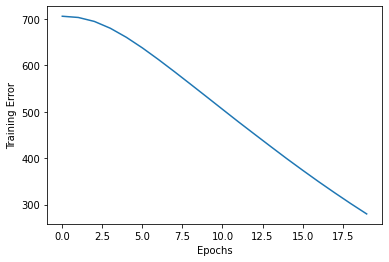

In [20]:
#Model error
#https://github.com/tensorflow/tensorflow/issues/23698

from keras.models import load_model

if os.path.exists('model.h5'):
    model = load_model('model.h5')
else:
    history = model.fit([train.user, train.pet], train.num_aifs, epochs=20, verbose=1)
    model.save('model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [76]:
# Creating dataset for making recommendations for the first user
select_user = 1750
pet_data = np.array(list(set(train.pet)))
user = np.array([select_user for i in range(len(pet_data))])
predictions = model.predict([user, pet_data])
predictions = np.array([a[0] for a in predictions])
recommended_pet_ids = (-predictions).argsort()[:10]
print(recommended_pet_ids)
print("----------------------------------------------------------------------")
print(predictions[recommended_pet_ids])

[27470 26459 19056 21473 43020 27442 26957  4597   569 34362]
----------------------------------------------------------------------
[81.32842  52.7943   49.89732  49.305763 49.266125 44.646595 40.218704
 39.638916 39.29772  34.380886]


In [67]:
# view all the pets this user liked
# use the user_enc to get the original user_id as it exists in the petfinder dataset
datatest[datatest.user_id == user_enc.inverse_transform([select_user])[0]]

,user_id,id,Description_Flag,mixed_breed,animal_type,age,state_code,primary_breed,organization_type,gender,size,num_aifs,house_trained,coat_length,num_videos,num_photos,good_with_dogs,good_with_cats,good_with_children
9504,3539257,45080137,1,0,Dog,Adult,FL,Toy Fox Terrier,Unknown,Female,Small,38,0,NaN,0,2,yes,yes,unknown
9508,3539257,46907857,1,0,Dog,Young,FL,Terrier,Private Animal Shelter,Female,Small,23,1,Wire,0,3,unknown,unknown,no
9581,3539257,46920839,1,1,Dog,Adult,FL,Bichon Frise,Private Animal Shelter,Male,Small,17,0,Medium,0,3,unknown,unknown,unknown
9587,3539257,46965356,0,0,Dog,Adult,FL,Rat Terrier,Rescue Group / Foster-Based,Male,Medium,0,0,NaN,0,3,unknown,unknown,unknown
9588,3539257,46842947,1,1,Dog,Young,FL,Yorkshire Terrier,Rescue Group / Foster-Based,Female,Small,8,0,NaN,0,3,yes,unknown,unknown
9592,3539257,46299579,1,1,Dog,Young,FL,Yorkshire Terrier,Rescue Group / Foster-Based,Male,Small,17,1,NaN,0,3,yes,unknown,unknown
9603,3539257,46088266,1,0,Dog,Adult,FL,Poodle,Unknown,Male,Medium,23,0,Long,0,1,unknown,unknown,no
9611,3539257,46749199,1,0,Dog,Young,FL,English Bulldog,Rescue Group / Foster-Based,Male,Medium,5,0,Short,0,4,yes,yes,yes
9612,3539257,46749196,1,0,Dog,Adult,FL,English Bulldog,Rescue Group / Foster-Based,Male,Medium,5,0,Short,0,1,yes,yes,yes
9614,3539257,46749188,1,0,Dog,Young,FL,English Bulldog,Rescue Group / Foster-Based,Male,Medium,28,0,Short,0,2,yes,yes,yes


In [68]:
# use pet_enc to get the original pet's id as it exists in the petfinder dataset
original_ids = []
for pet_id in recommended_pet_ids:
    original_ids.append(pet_enc.inverse_transform([pet_id])[0])
    
# view the user's top 10 recommended pets
datatest[datatest.id.isin(original_ids)].drop_duplicates(subset="id", keep="first")

,user_id,id,Description_Flag,mixed_breed,animal_type,age,state_code,primary_breed,organization_type,gender,size,num_aifs,house_trained,coat_length,num_videos,num_photos,good_with_dogs,good_with_cats,good_with_children
6696,4161441,45022822,1,0,Cat,Adult,AZ,Ragdoll,Unknown,Male,Small,33,1,Long,0,5,unknown,yes,unknown
7301,4371087,46930276,0,0,Dog,Adult,WI,Mixed Breed,Private Animal Shelter,Female,Medium,0,0,NaN,0,3,unknown,unknown,unknown
7536,4370668,46712095,1,1,Dog,Young,NJ,Pit Bull Terrier,Private Animal Shelter,Female,Medium,2,0,Short,0,3,unknown,unknown,no
15597,4317358,43927189,1,0,Dog,Senior,VA,Italian Greyhound,Unknown,Female,Large,4,1,Short,0,1,yes,yes,unknown
24740,4374341,46842019,1,1,Cat,Young,MD,Siamese,Private Animal Shelter,Male,Medium,8,1,Short,0,1,unknown,yes,unknown
28503,4353987,46465285,1,1,Dog,Adult,CA,Chow Chow,Rescue Group / Foster-Based,Male,Medium,37,1,Medium,1,5,yes,unknown,no
47533,4378850,46700270,0,0,Dog,Adult,IN,Staffordshire Bull Terrier,Municipal Animal Shelter,Female,Medium,6,0,NaN,0,6,unknown,unknown,unknown
48853,3616089,46724444,1,1,Dog,Baby,CA,Terrier,Rescue Group / Foster-Based,Male,Small,9,1,Medium,0,3,yes,unknown,unknown
52278,4181359,46723723,1,1,Cat,Baby,TX,Domestic Short Hair,Rescue Group / Foster-Based,Male,Medium,3,1,Short,0,6,unknown,yes,unknown
105626,4175967,46558063,0,0,Dog,Adult,CO,Labrador Retriever,Rescue Group / Foster-Based,Male,Medium,6,0,NaN,0,5,unknown,unknown,unknown
